In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

from cycifsuite.get_data import read_synapse_file
from cycifsuite.combat import combat
from cycifsuite.unsupervised_analysis import *

from umap import UMAP
from sklearn.preprocessing import scale
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

## Load data from Synapse and ComBat batch removal

In [2]:
expr_data = pd.read_hdf(read_synapse_file('syn18504942'))
metadata = pd.read_csv(read_synapse_file('syn18501468'), index_col=0)
metadata = metadata.loc[expr_data.index]
assert((metadata.index==expr_data.index).all())
feature_metadata = pd.read_json(read_synapse_file('syn18502301')).transpose()
# add nuclear to cytoplasm ratio
nucs = feature_metadata[(feature_metadata.feature_type=='mean')&(feature_metadata.sublocation=='nuc')&(feature_metadata.marker!='none')].index
cytoplasms = feature_metadata[(feature_metadata.feature_type=='mean')&(feature_metadata.sublocation=='cytoplasm')&(feature_metadata.marker!='none')].index
nc_ratio = np.divide(expr_data[nucs], expr_data[cytoplasms])
# Replace nulls division by 0 nulls by mean
from sklearn.impute import SimpleImputer
imputor = SimpleImputer(strategy='mean')
nc_ratio.loc[:,:] = imputor.fit_transform(nc_ratio)
nc_ratio.columns = [x.replace('mean','NC-ratio') for x in nc_ratio.columns]
expr_data = pd.concat([expr_data,nc_ratio],axis=1)
# Normlalizing and combat
expr_data = expr_data - expr_data.min()
expr_data.loc[:,:] = scale(np.log2(expr_data + 1))
combat_norm_data = combat(expr_data.transpose(), metadata.replicate).transpose()
assert(combat_norm_data.notnull().all(axis=None))

Welcome, Yunguan Wang!

Welcome, Yunguan Wang!

Welcome, Yunguan Wang!



[WARNING] C:\WinPython\python-3.6.5.amd64\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':

found 3 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments


Adjusting data


## Selecting only features with a marker and not later cycle DAPI

In [3]:
# Select columns
valid_cols = [x for x in combat_norm_data.columns if 'none' not in x]
dna_cols = [x for x in combat_norm_data.columns if 'dna_1' in x]
valid_cols = [x for x in valid_cols if 'dna_' not in x]
valid_cols = valid_cols + dna_cols
# valid_cols = [x for x in valid_cols if 'background' not in x]

## Umap dimension reduction, will use previously save data if it exists.

In [4]:
umap_data_fn = 'N:/HiTS Projects and Data/Personal/Jake/mcf10a/unsupervised_analysis/umap_2d_expr_data_with_NC_ratio.csv'
if os.path.exists(umap_data_fn):
    umap_data=pd.read_csv(umap_data_fn,index_col=0)
else:
    pca = PCA(0.95)
    pca_data = pca.fit_transform(combat_norm_data[valid_cols])
    umap=UMAP(n_components=2)
    umap_data = umap.fit_transform(pca_data)
    umap_data = pd.DataFrame(umap_data, columns=['X1','X2'], index = combat_norm_data.index)
    umap_data['ligand'] = metadata.ligand
    umap_data['time'] = metadata.time
    umap_data = umap_data.sort_values('ligand')
    umap_data.to_csv(umap_data_fn)
umap_data = umap_data.merge(metadata[['replicate']],left_index=True,right_index=True, how='left')

## Plotting single cell data on UMAP space with colors mapped to ligand, time and replicates.
### This is also Figure 8 in the method document.

Text(0, 0.5, 'UMAP2')

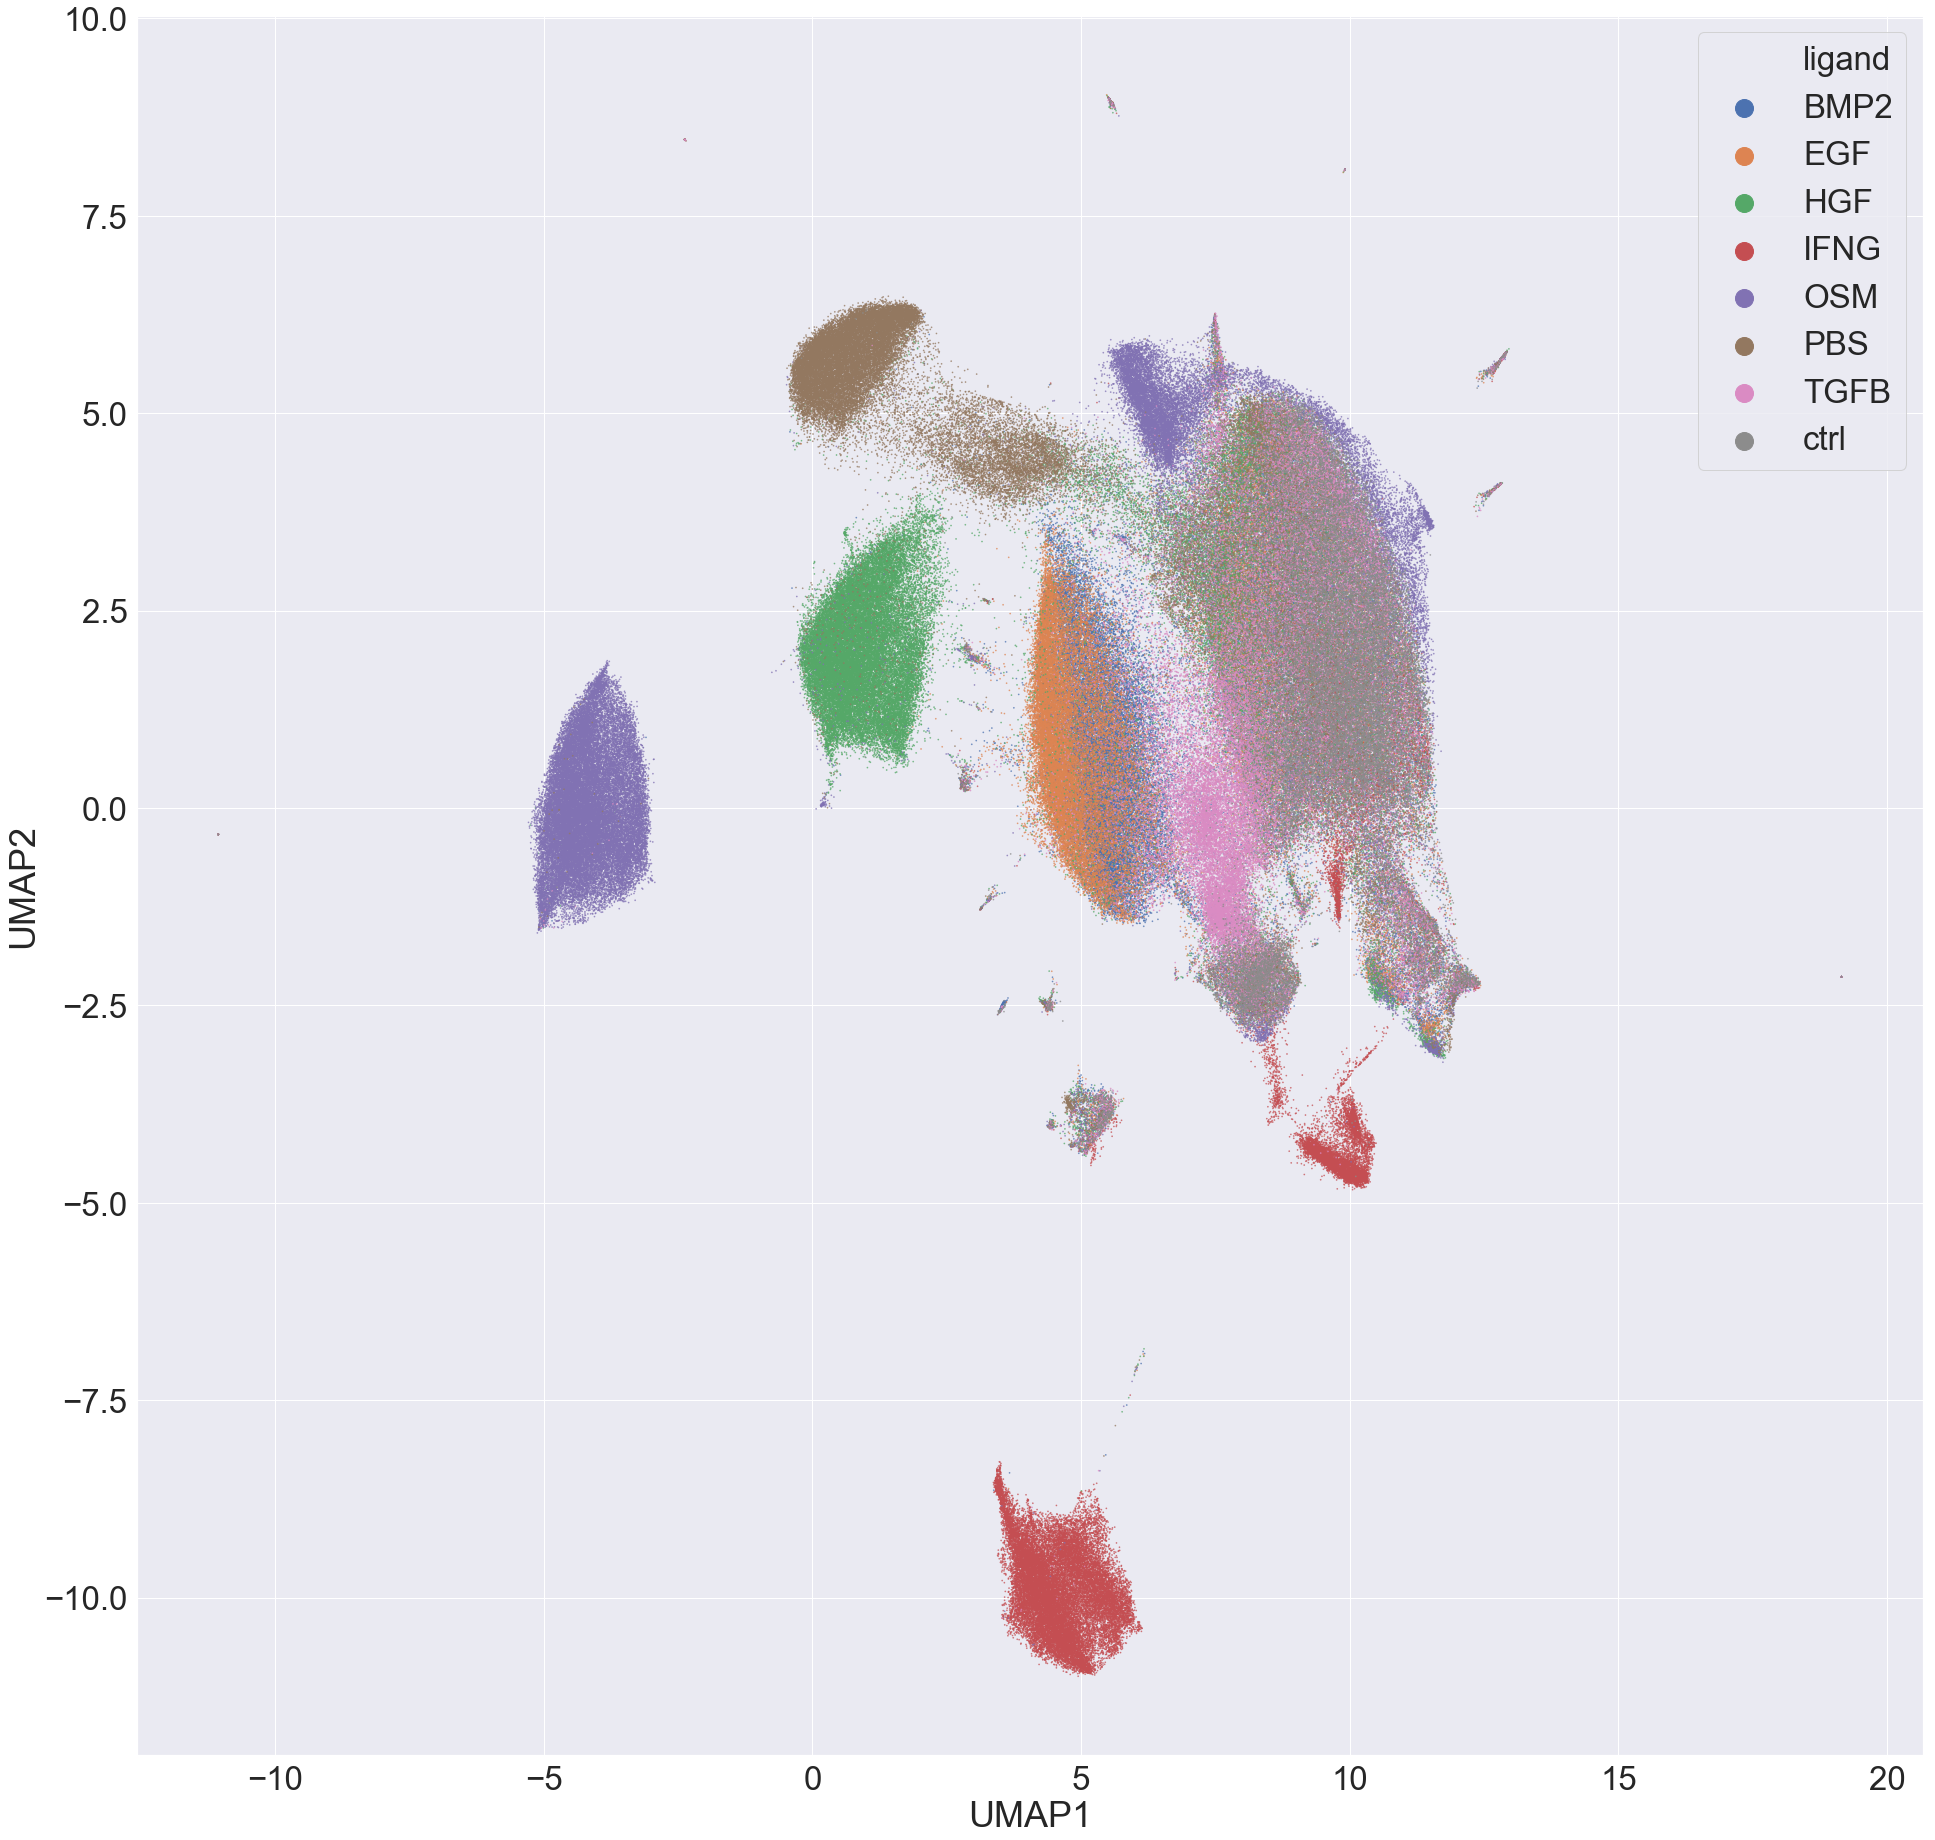

In [5]:
sns.set(font_scale=3)
plt.figure(figsize=(32,32))
sns.scatterplot('X1','X2',data=umap_data, hue='ligand', s=1, legend='full', edgecolor=None, alpha = 0.6)
plt.legend(markerscale=3)
_, plt.xlabel('UMAP1')
_, plt.ylabel('UMAP2')

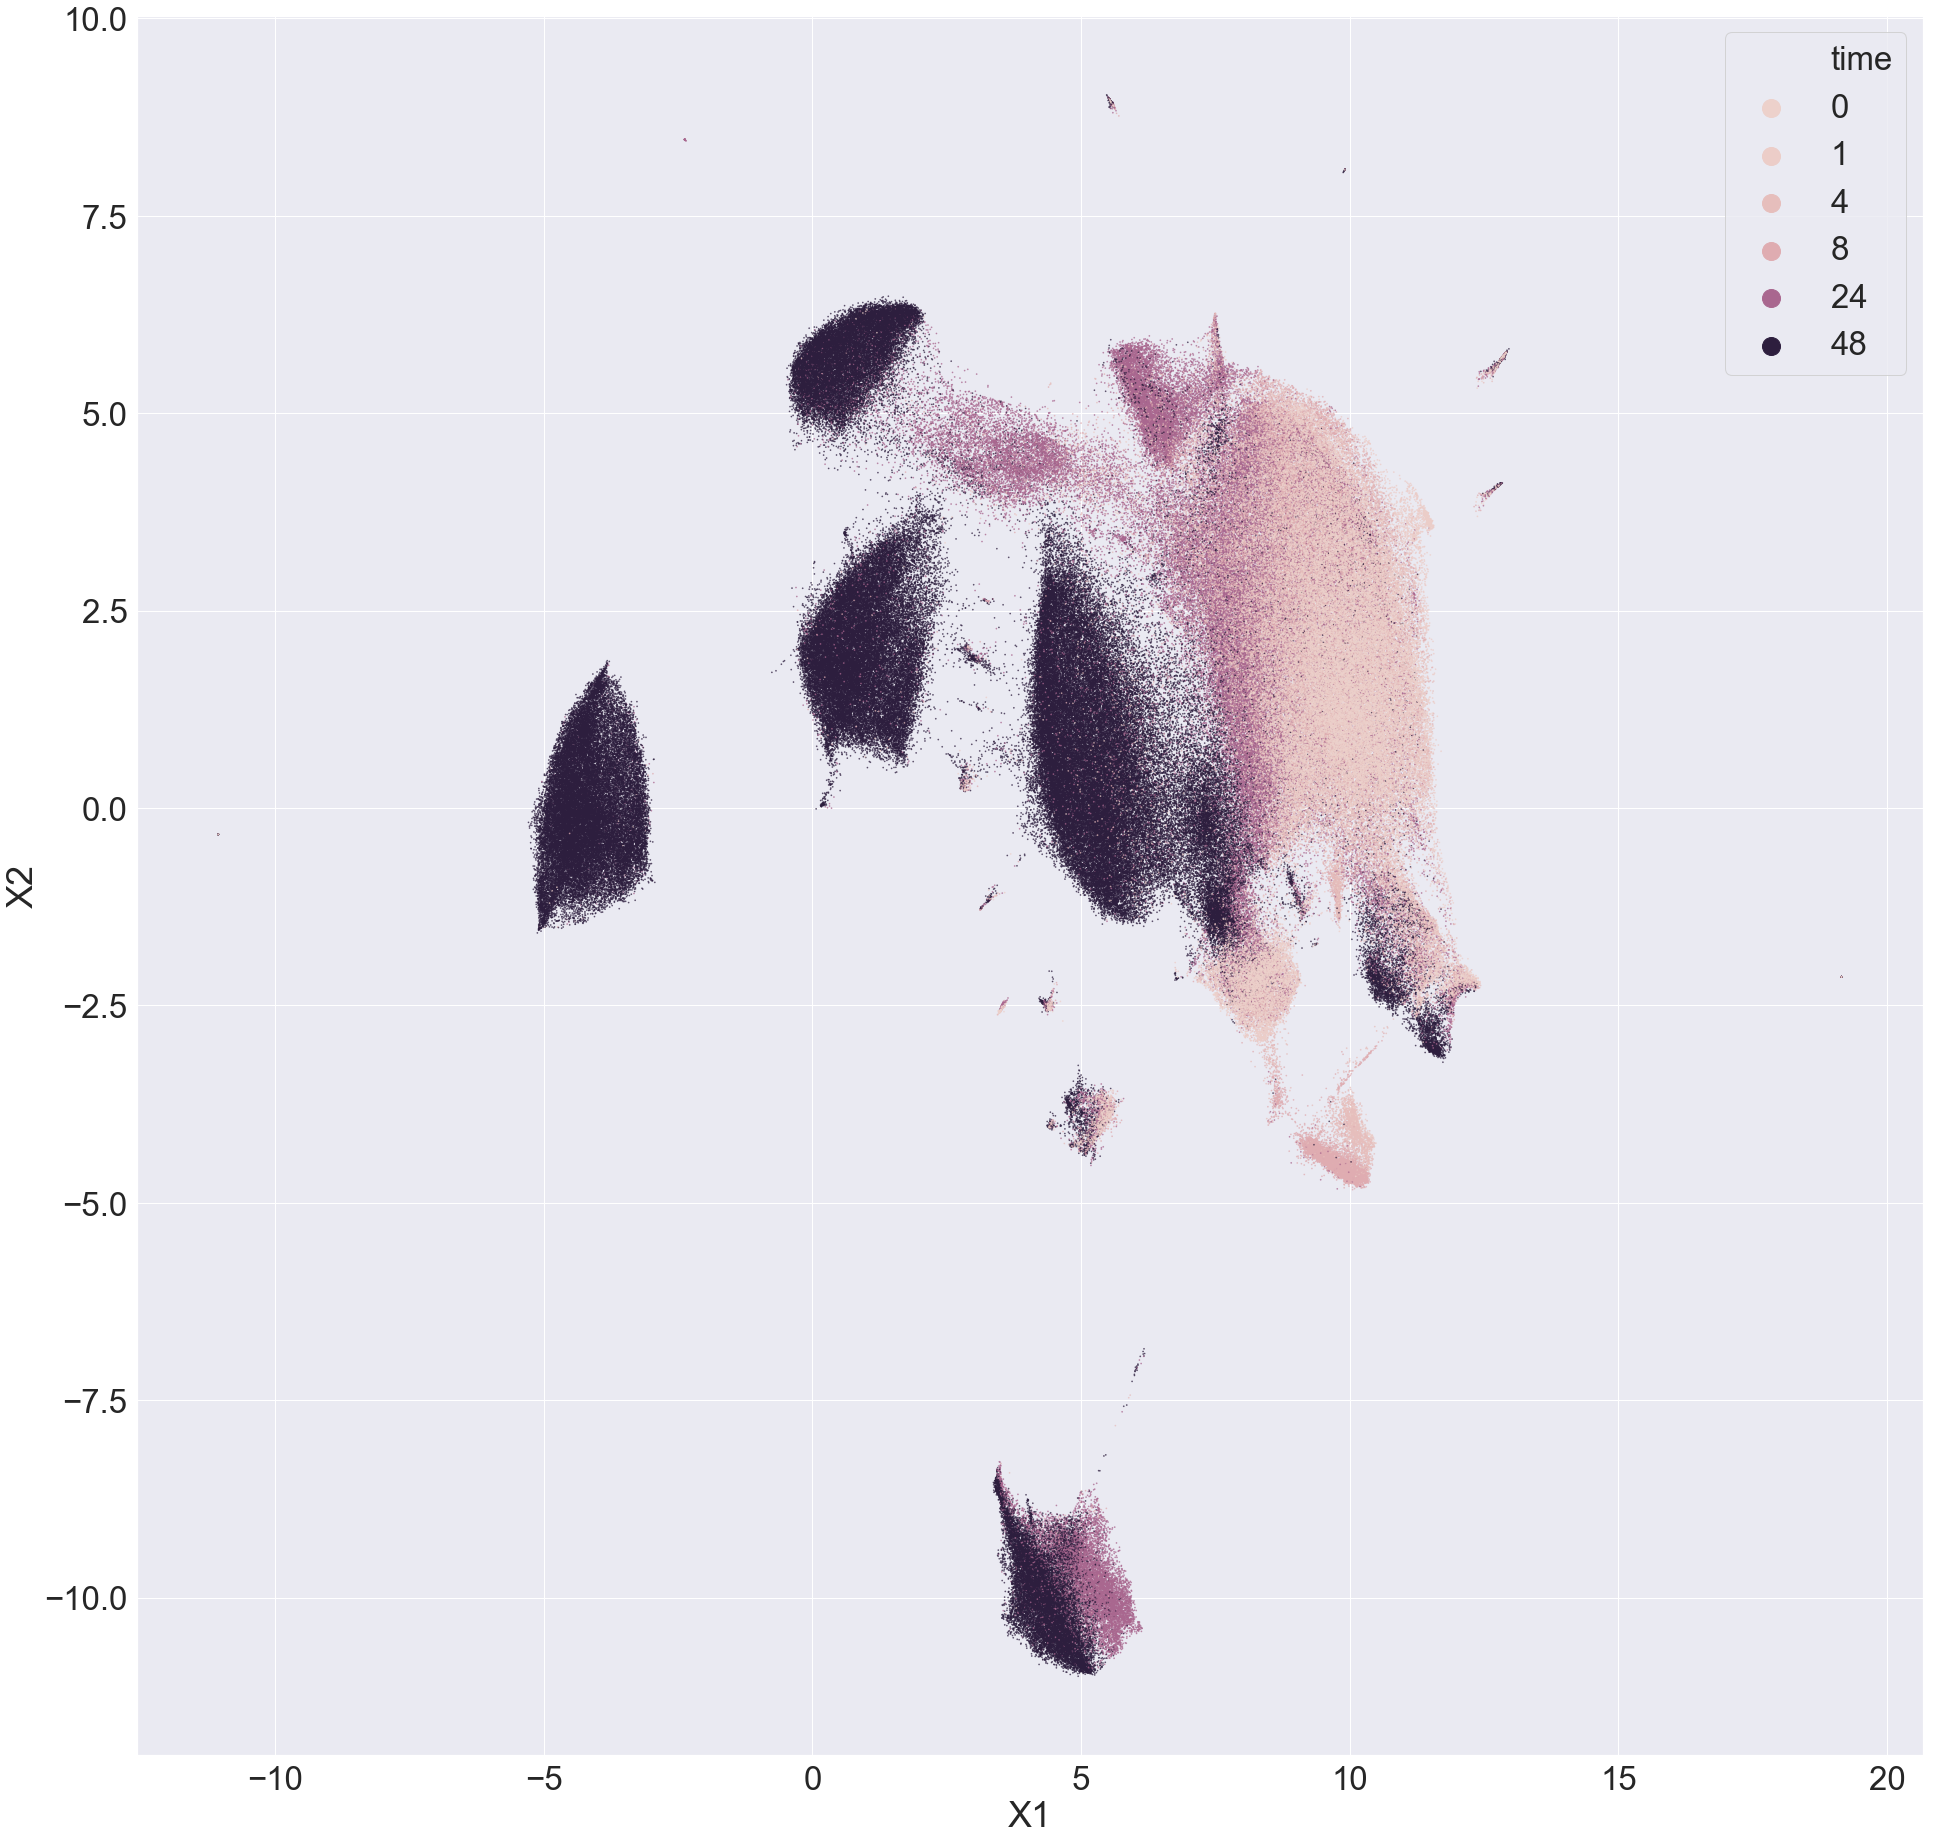

In [7]:
sns.set(font_scale=3)
plt.figure(figsize=(32,32))
sns.scatterplot('X1','X2',data=umap_data, hue='time', s=1, legend='full', edgecolor=None, alpha = 0.6)
plt.legend(markerscale=3)

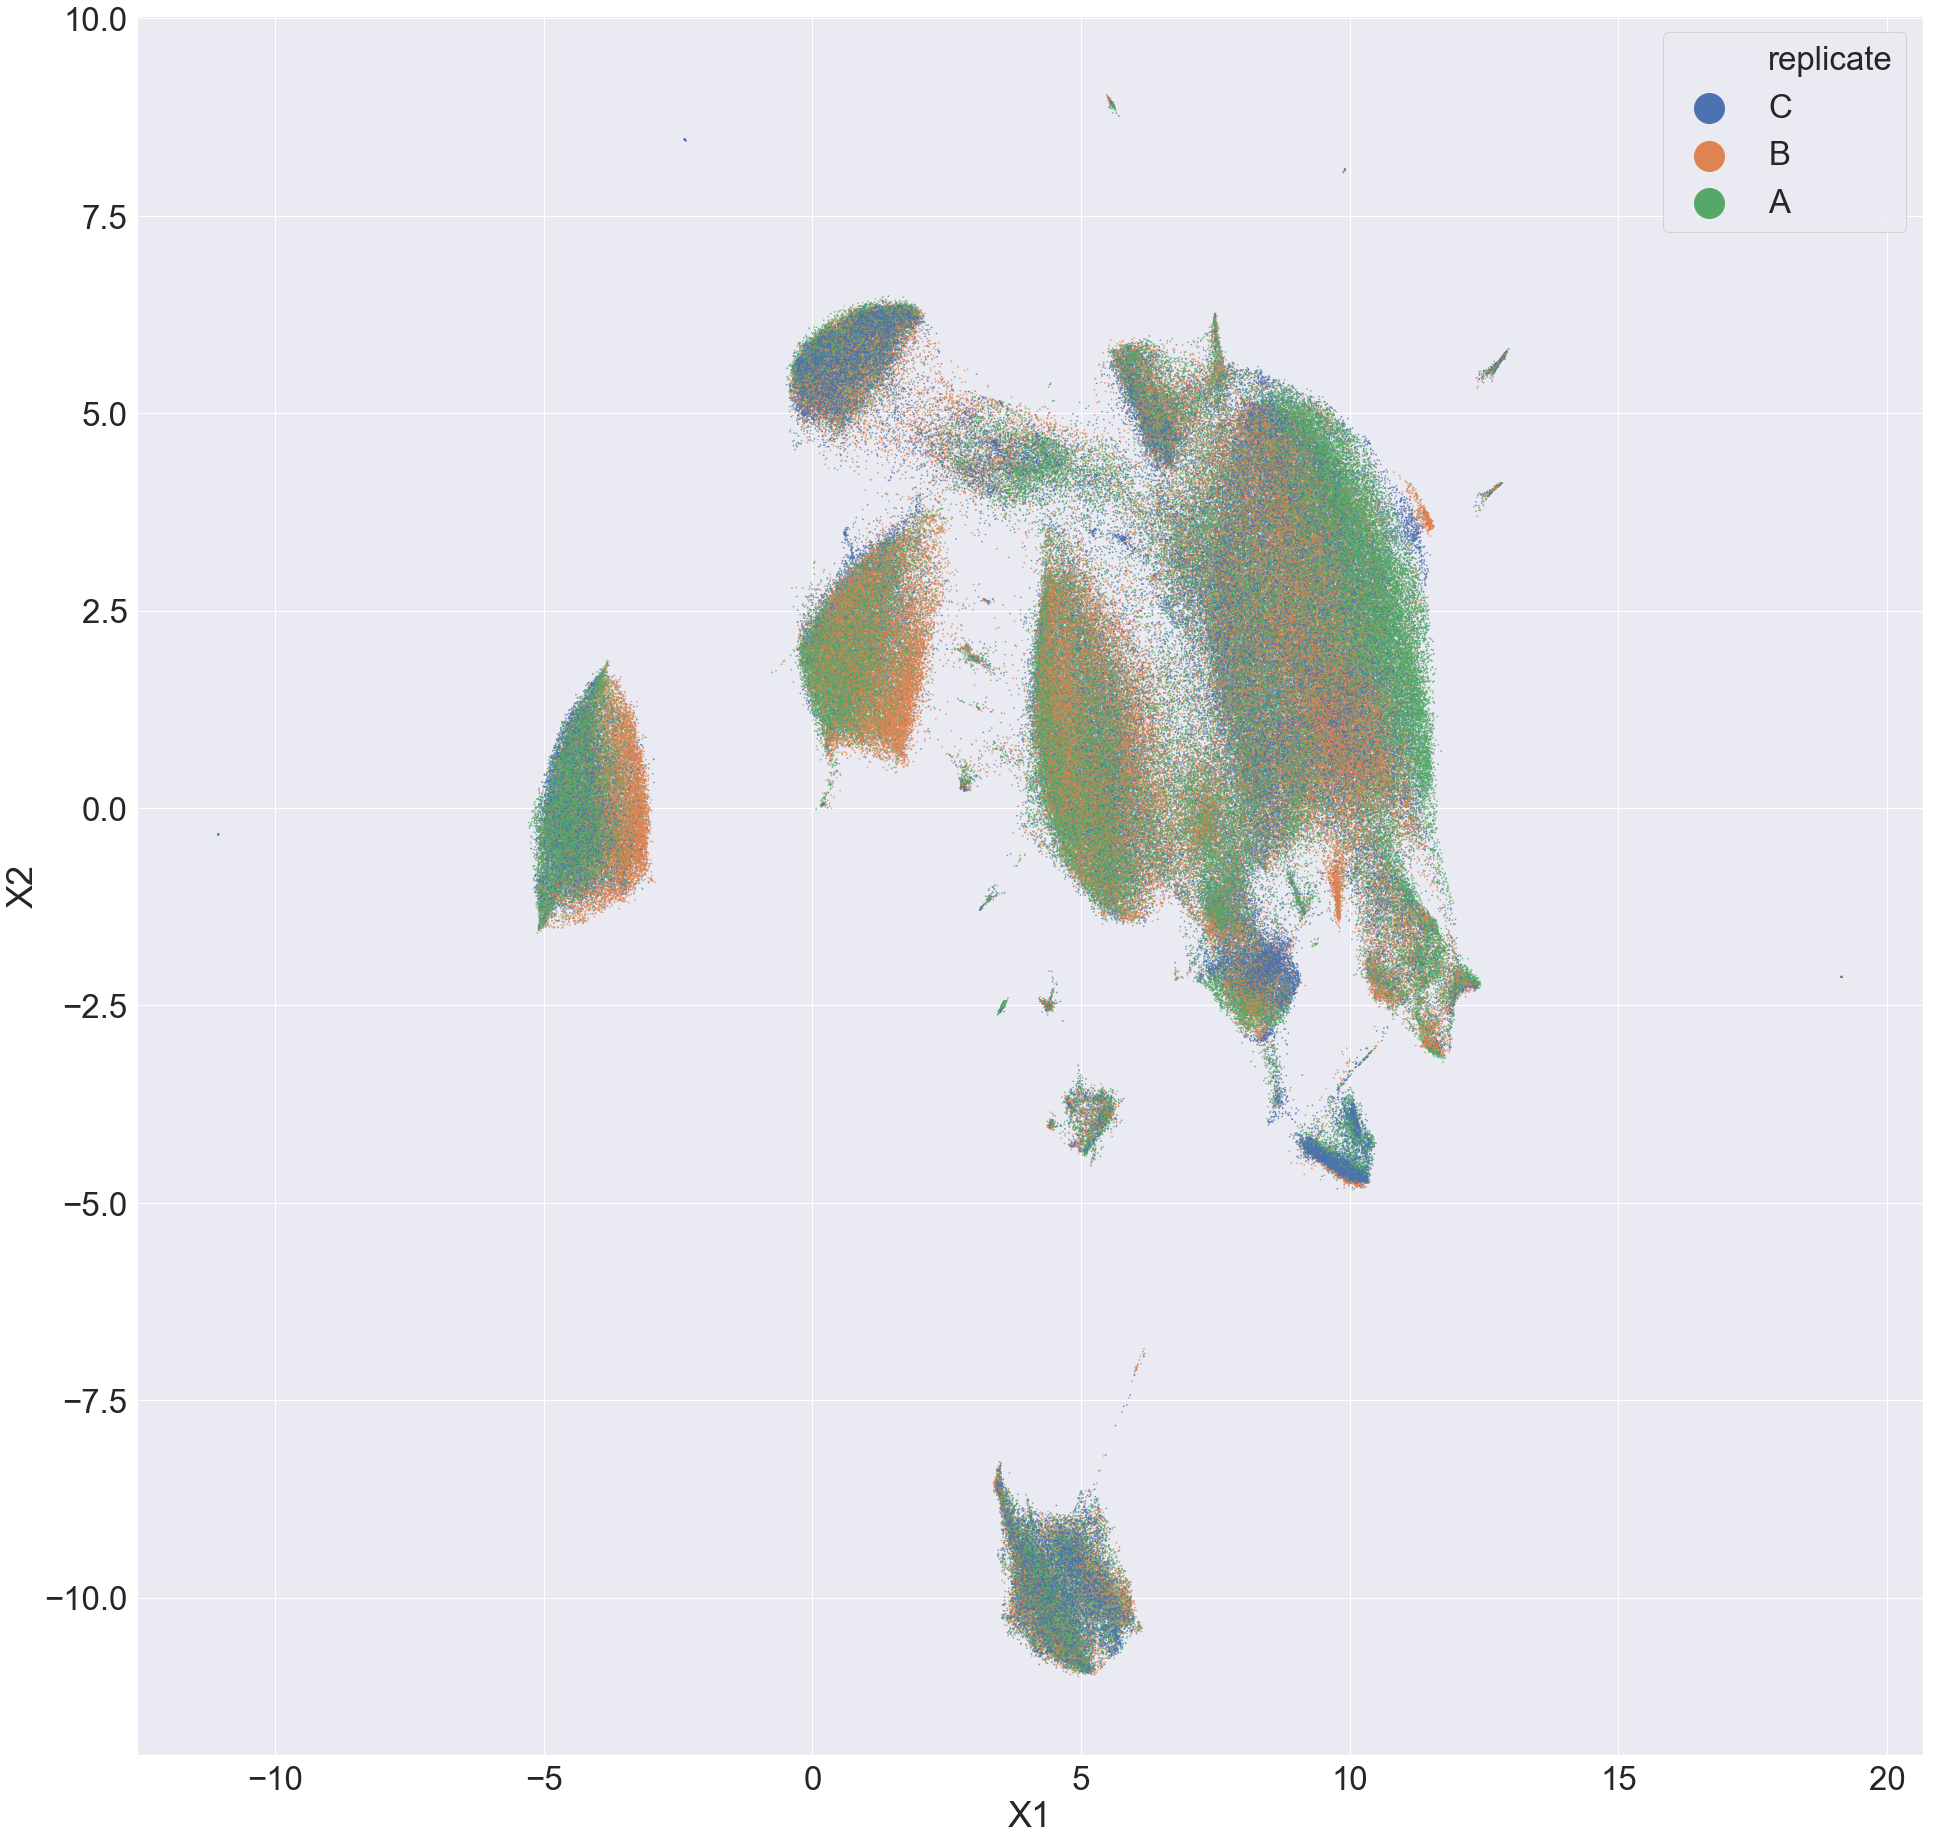

In [8]:
plt.figure(figsize=(32,32))
sns.scatterplot('X1','X2',data=umap_data, hue='replicate', s=1, legend='full', edgecolor = None, alpha=0.6)
plt.legend(markerscale=5)

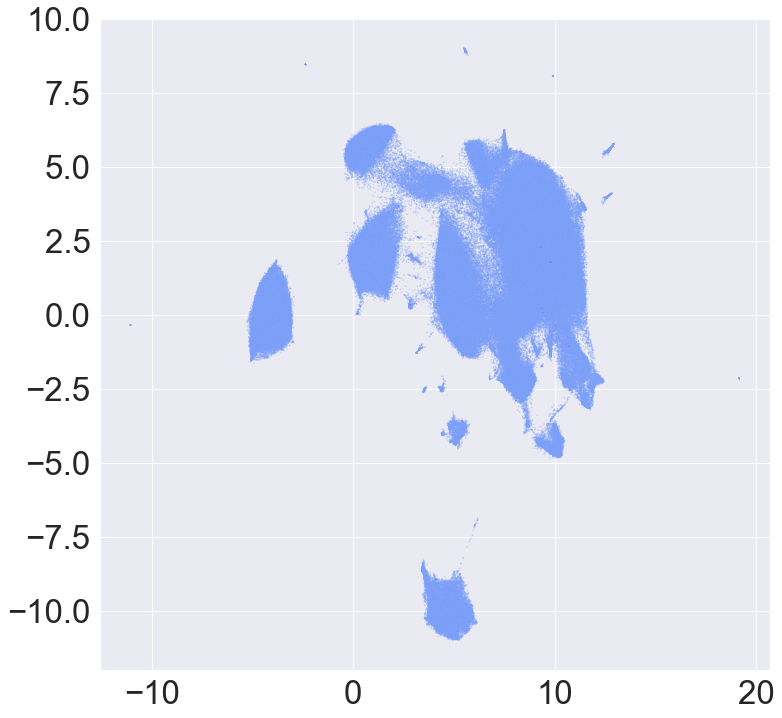

In [13]:
# Check for background dominating signals
all_bgnd = [x for x in combat_norm_data.columns if 'background' in x]
all_bgnd = combat_norm_data[all_bgnd]
all_bgnd = (all_bgnd - all_bgnd.min())/(all_bgnd.max() - all_bgnd.min())
all_bgnd_col_max = all_bgnd.max(axis=1)
plt.figure(figsize=(12,12))
_ = plt.scatter(umap_data.X1.values,umap_data.X2.values,c=all_bgnd_col_max.loc[umap_data.index], s=0.1, alpha=0.6, cmap='coolwarm')

## HDBSCAN clustering
Note: a random seed is used

[WARNING] C:\WinPython\python-3.6.5.amd64\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)

[WARNING] C:\WinPython\python-3.6.5.amd64\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)

[WARNING] C:\WinPython\python-3.6.5.amd64\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)

[WARNING] C:\WinPython\python-3.6.5.amd64\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)



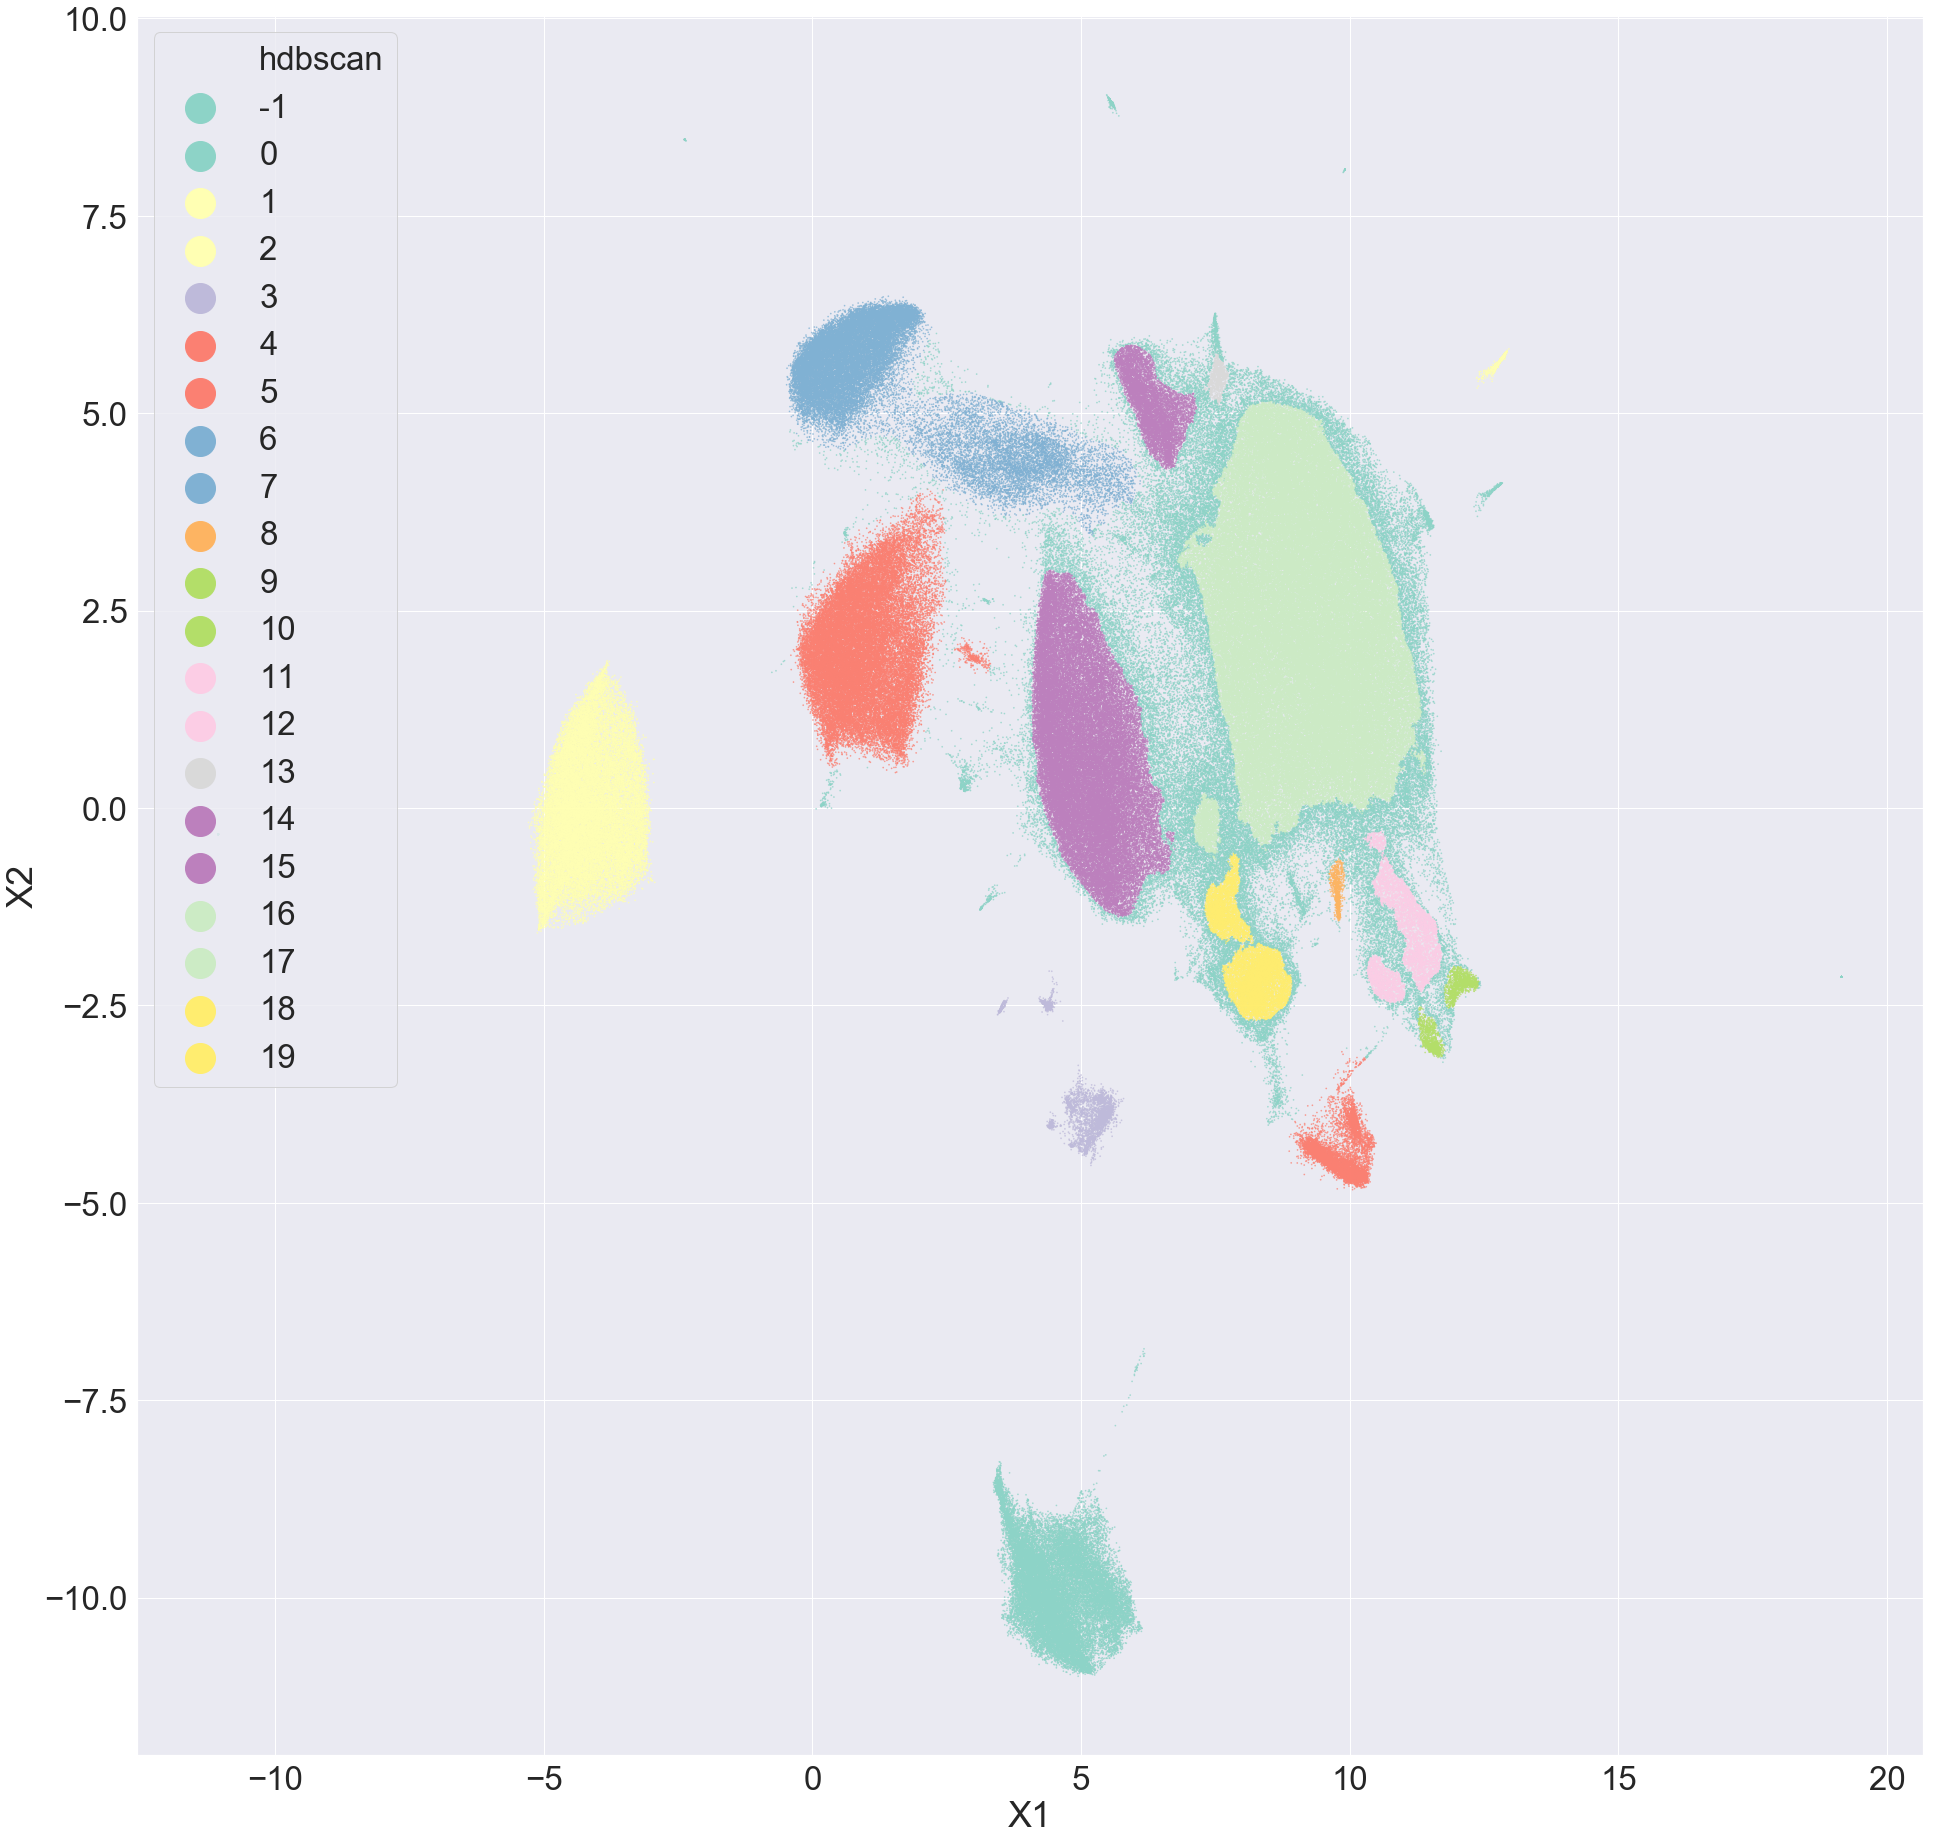

In [9]:
from hdbscan import HDBSCAN
np.random.seed(999)
cluster_estimator = HDBSCAN(min_cluster_size=500,min_samples=200, memory='d:/data/')
labels = cluster_estimator.fit_predict(umap_data.iloc[:,:2])
umap_data['hdbscan'] = labels
sns.set(font_scale=3)
plt.figure(figsize=(32,32))
sns.scatterplot('X1','X2',data=umap_data, hue='hdbscan',legend='full',palette='Set3', edgecolor=None, s=1, alpha=0.6)
plt.legend(markerscale=5)
# plt.savefig('umap_hdbscan.png')

## Evaluating cluster composition.
#### Note: Cluster -1, 2, 3, 10 was dropped due to its very small size and highly mixed nature

In [19]:
umap_data['cond'] = umap_data.ligand + '_' + umap_data.time.astype(str)
cluster_comp = umap_data.groupby(['hdbscan', 'cond']).count().X1/umap_data.groupby('hdbscan').count().X1
clusters = umap_data.hdbscan.copy()
clusters = clusters[~clusters.isin([-1,2,3,10])]
for cluster in sorted(clusters.unique()):
    top_3 = cluster_comp.loc[cluster].sort_values(ascending=False)[:3]
    print(cluster, ', '.join(top_3.index), ' : ', ', '.join(top_3.values.round(2).astype(str)))
    if cluster != -1:
        clusters[clusters == cluster] = '_'.join(top_3.index[:3]) + '({:.2f}) C_{}'.format(top_3.sum(), str(cluster))
cluster_sizes = pd.DataFrame(clusters.groupby(clusters).count()/clusters.shape[0] * 100).round(1)
cluster_sizes.loc[:, 'new_name'] = cluster_sizes.iloc[:,0].astype(str) + '%_' + cluster_sizes.index
clusters[:] = cluster_sizes.loc[clusters.values,'new_name'].values

0 IFNG_48, IFNG_24, IFNG_8  :  0.64, 0.35, 0.0
1 OSM_48, OSM_24, HGF_48  :  0.98, 0.02, 0.0
4 IFNG_8, IFNG_4, IFNG_1  :  0.72, 0.24, 0.03
5 HGF_48, PBS_24, OSM_48  :  0.97, 0.01, 0.01
6 PBS_48, PBS_24, HGF_48  :  0.95, 0.03, 0.01
7 PBS_24, HGF_24, PBS_48  :  0.68, 0.09, 0.06
8 IFNG_4, IFNG_8, IFNG_1  :  0.64, 0.29, 0.01
9 HGF_48, OSM_48, EGF_48  :  0.35, 0.28, 0.17
11 BMP2_48, EGF_48, HGF_48  :  0.26, 0.26, 0.25
12 ctrl_0, TGFB_48, BMP2_24  :  0.14, 0.06, 0.05
13 OSM_24, EGF_24, BMP2_24  :  0.42, 0.11, 0.1
14 OSM_24, OSM_8, OSM_48  :  0.87, 0.07, 0.03
15 EGF_48, BMP2_48, TGFB_48  :  0.49, 0.45, 0.03
16 ctrl_0, BMP2_24, EGF_24  :  0.17, 0.07, 0.07
17 TGFB_48, TGFB_24, BMP2_48  :  0.87, 0.05, 0.03
18 ctrl_0, TGFB_24, HGF_1  :  0.25, 0.04, 0.04
19 TGFB_48, TGFB_24, ctrl_0  :  0.67, 0.19, 0.02


## Downstream analysis and differential analysis
### Get top upregulated genes in each cluster

In [20]:
from cycifsuite.common_apis import differential_analysis
report = pd.DataFrame()
for cluster in clusters.unique():
    query = clusters[clusters==cluster].index
    ref = clusters[clusters!=cluster].index
    _cluster_report = pd.DataFrame(combat_norm_data.loc[query, valid_cols].mean() - combat_norm_data.loc[ref,valid_cols].mean())
    _cluster_report['cluster'] = '_'.join(['cluster',str(cluster)])
    report = report.append(_cluster_report)

report.columns = ['logFC', 'cluster']
report['absFC'] = np.abs(report.logFC)
report = report.sort_values('absFC', ascending=False)
top_genes = report.groupby('cluster').head(3).index.unique()

## Plotting
### Correlation heatmap of top genes

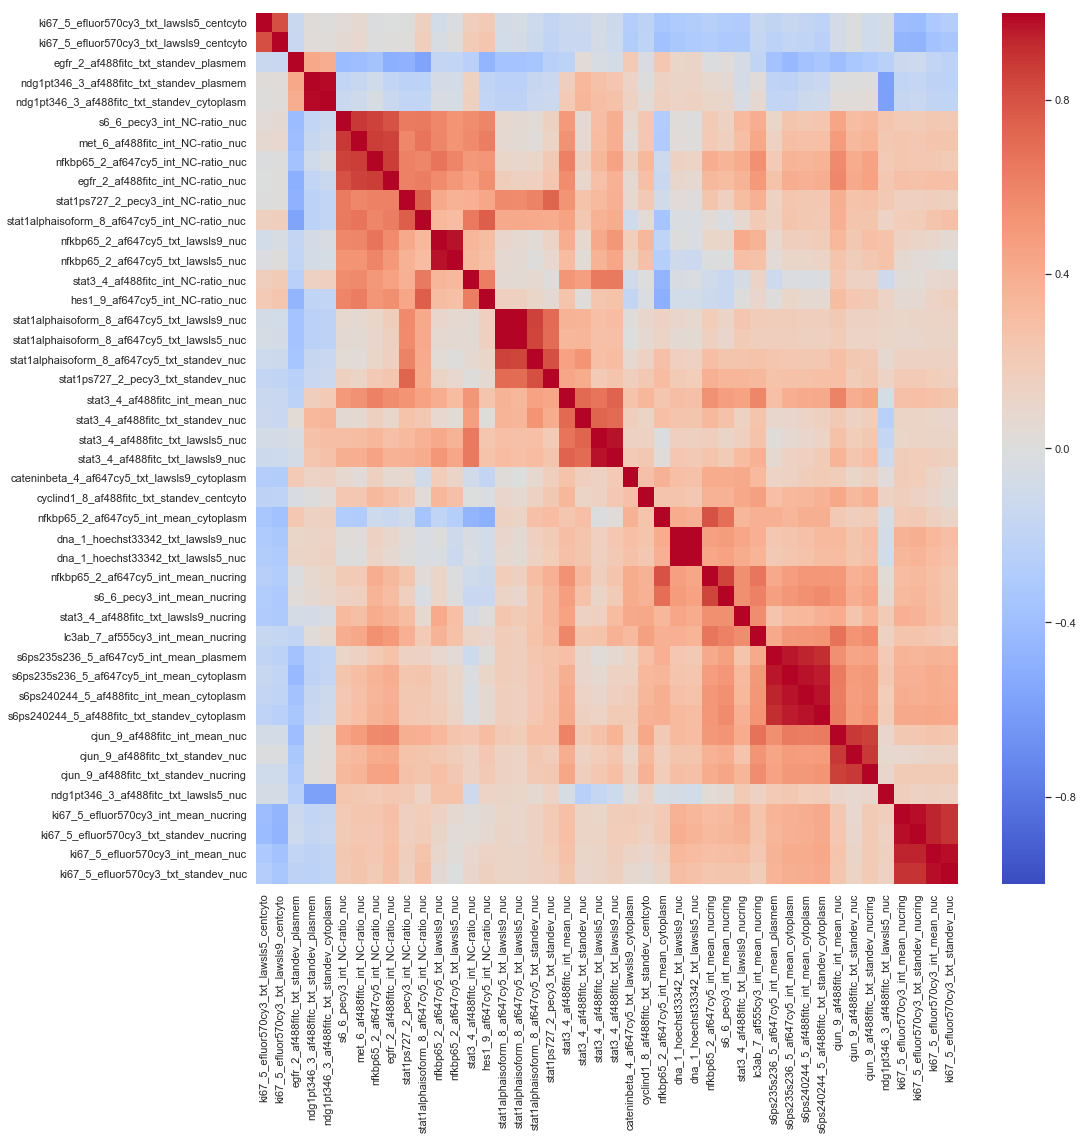

In [22]:
from cycifsuite.common_apis import two_way_hc_ordering
sns.set(font_scale=1)
marker_cor = combat_norm_data[top_genes].corr()
r_o, c_o = two_way_hc_ordering(marker_cor)
plt.figure(figsize=(16,16))
sns.heatmap(marker_cor.iloc[r_o,c_o], cmap='coolwarm', vmin=-1, vmax=1)
plt.tight_layout()
# plt.savefig('top_DE_genes_corr.png')

## Gene expression pattern in clusters

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5]),
 <a list of 17 Text xticklabel objects>)

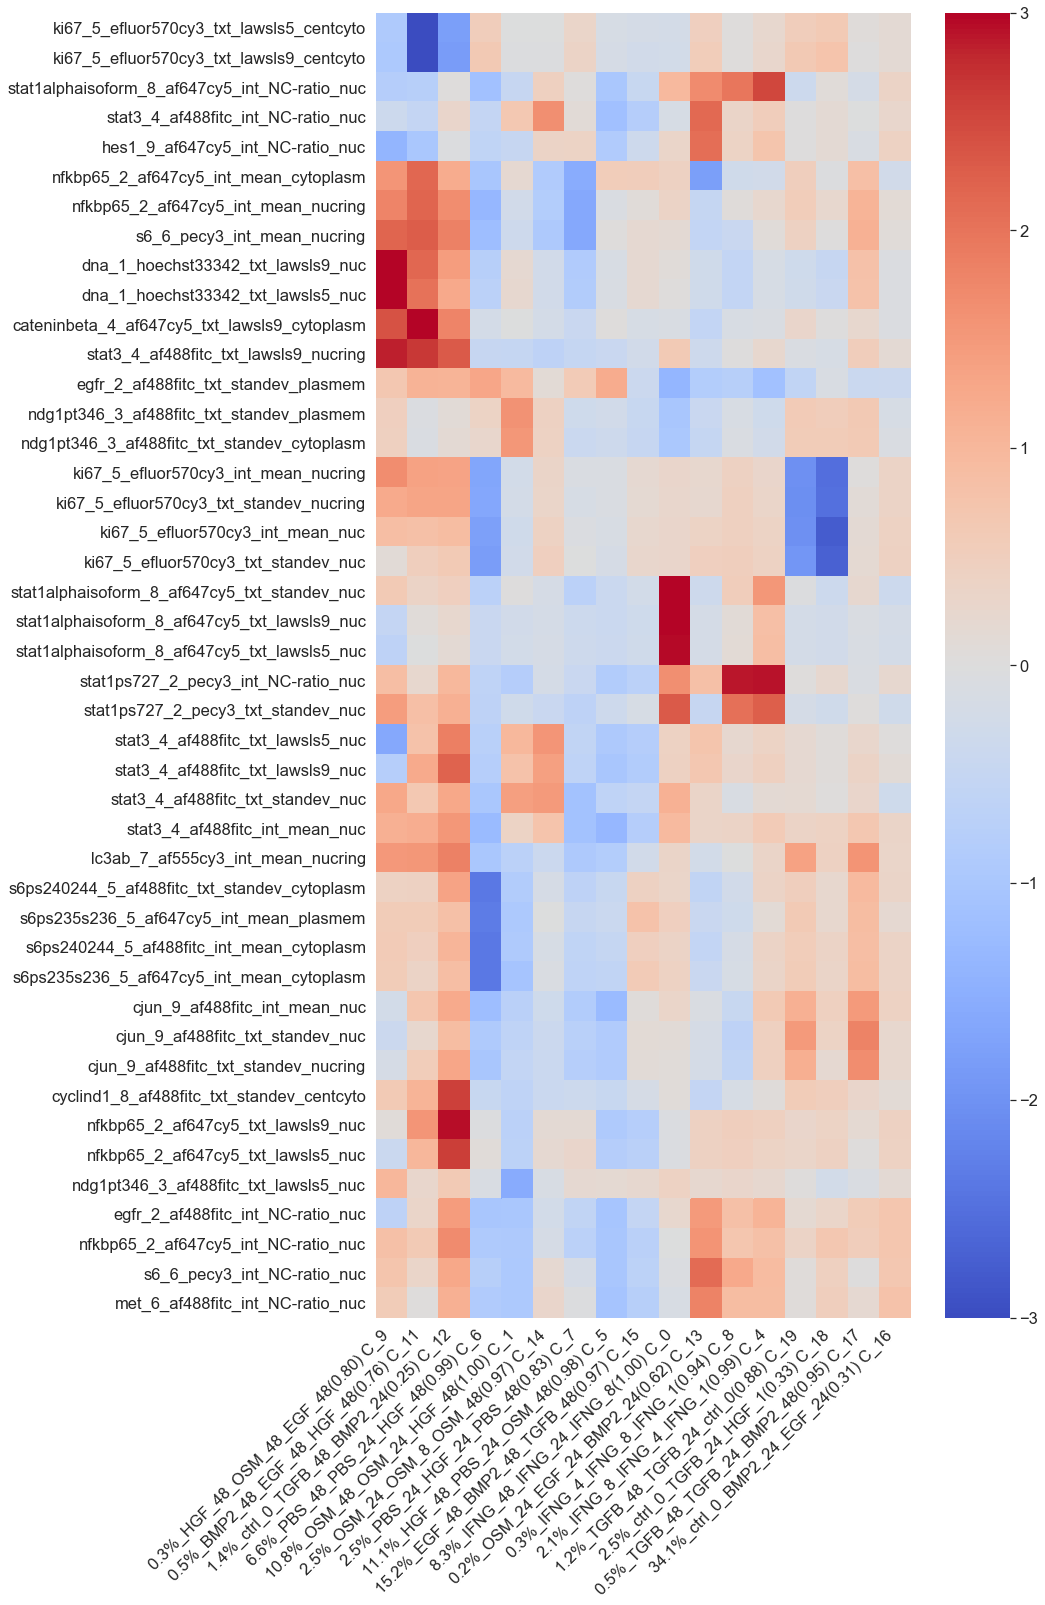

In [23]:
from sklearn.preprocessing import scale
from cycifsuite.common_apis import two_way_hc_ordering
sns.set(font_scale=1.5)
gmm_cluster_heatmap = combat_norm_data.loc[clusters.index, top_genes].groupby(clusters.values).mean()
gmm_cluster_heatmap.loc[:,:] = gmm_cluster_heatmap
r_o, c_o = two_way_hc_ordering(gmm_cluster_heatmap)
plt.figure(figsize=(12,24))
sns.heatmap(gmm_cluster_heatmap.iloc[r_o,c_o].transpose(), vmax=3, vmin=-3, cmap='coolwarm',yticklabels=1, xticklabels=1)
plt.xticks(rotation=45,ha='right')
# plt.tight_layout()
# plt.savefig('umap_gmm_9_cluster_zscore.png')